In [69]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


Toggle code

In [70]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
np.random.seed(0)
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [71]:
pl.style.use('fabiostyle')
# needs to find the library of functions
sys.path.append('../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [72]:
NOTEBOOK_NAME = 'overlaps_d1d2'

In [73]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

In [74]:
from itertools import product
def load_all_animals_vars(varname, animal_list, pilot_list=None, notebook='preprocessing'):
    all_of_them = {}
    for ani in animal_list:
        folder = '../%s/notebooks/autorestore/%s/' % (ani, notebook)
        all_of_them.update({ani: ut.load_variable(varname, folder)})
    return all_of_them

In [102]:
all_animals = '52', '64', '991', 'NEW_58', #'NEW_57_1day'#, 'NEW_991b'

animals = all_animals
prod = product(['pre', 'post'], ['rew', 'sho'], ['all', ''],['_constrained'])

# load data for constrained selectivity
animals = all_animals
prod = product(['pre', 'post'], ['rew', 'sho'], ['all', ''])
for a, b, c in prod:
    try:
        what = np.concatenate([ut.load_variable('cells_%s%s_%s_constrained'%(c, a, b), '../%s/notebooks/autorestore/tuning_stability_values/'%ani)
                               for ani in animals])
        exec('cells_%s%s_%s_constrained = what'%(c, a, b))
    except IOError:
        print("Skip", ani, a, b, c)


In [103]:
print len(cells_pre_rew_constrained)
print len(cells_post_rew_constrained)
print len(cells_pre_rew)
print len(cells_post_rew)

138
138
138
138


In [104]:
# load data
animals = all_animals
prod = product(['pre', 'post'], ['rew', 'sho'], ['all', ''])
for a, b, c in prod:
    try:
        what = np.concatenate([ut.load_variable('cells_%s%s_%s'%(c, a, b), '../%s/notebooks/autorestore/tuning_stability_values/'%ani)
                               for ani in animals])
        exec('cells_%s%s_%s = what'%(c, a, b))
    except IOError:
        print("Skip", ani, a, b, c)
        
# load data for constrained selectivity


In [105]:
N = len(cells_post_rew)
n_loops = 50000

def calc_shuffle_overlap(pop1, pop2, n_loops=500):
     return [(np.random.choice([0, 1], size=N, p=(1-pop1.mean(), pop1.mean()))*
                  np.random.choice([0, 1], size=N, p=(1-pop2.mean(), pop2.mean()))).mean() for r in range(n_loops)]



In [106]:
N = len(cells_post_rew_constrained)
n_loops = 50000

def calc_shuffle_overlap_constrained(pop1, pop2, n_loops=500):
     return [(np.random.choice([0, 1], size=N, p=(1-pop1.mean(), pop1.mean()))*
                  np.random.choice([0, 1], size=N, p=(1-pop2.mean(), pop2.mean()))).mean() for r in range(n_loops)]



In [107]:
def sigtest(values, x):
    return [None, 1 - sstats.norm(np.mean(values), np.std(values)).cdf(x)]
def plot_hist(ax, vals, colors=['0.7', 'k'], bins=np.linspace(0, 0.05, 30), ids=[0, 1]):
    # ax.hist(vals2_all[0], bins=10, histtype='step', color='0.7')
    y, x = np.histogram(vals[ids[0]], bins=bins, normed=True)
    ax.step(x[:-1], y*np.diff(x)[0], color=colors[0], lw=1, where='post')
    ax.vlines(vals[ids[1]], 0, 0.4, color=colors[1], lw=1, zorder=19)
    y = np.diff(ax.axis()[-2:])*0.95 + ax.axis()[-2]
    pt.add_significance(ax, vals[ids[0]], vals[ids[1]], vals[ids[1]], vals[ids[1]], y, sig_func=sigtest)
    pt.nicer_plot(ax)

In [108]:
def plot_it(pop1, pop2, untuned, est, labels=['Pre', 'Post', 'Pre+Post', 'Untuned'], title="Sucrose",
            colors=[(1, 0., 0.2), (1, 0.5, 0.2), (1, 0.8, 0.2), (0.8, 0.8, 0.8)],
            hist_colors=[(1, 0.7, 0.7), 'r']):
    fig, axs = pl.subplots(1, 2, figsize=(3, 1))

    ax = axs[0]
    plot_hist(ax, [est, (pop1*pop2).mean()], bins=np.linspace(0, 0.2, 30),
            colors=hist_colors)

    ax.set_xlabel('Co-tuned Cells Ratio')
    ax.set_ylabel('PDF')

    ax.set_xlim(0, 0.2)
    ax.set_ylim(0, 0.5)

    ax = axs[1]
    
    t = map(sum, [pop1*~pop2, pop2*~pop1, pop1*pop2, untuned])
    total = np.sum(t)
    _, txts, _ = ax.pie(t, colors=colors, explode=[0.05]*len(t),
                        autopct=lambda x: "%.1f%%"%(x),
                        labels=labels,
                        textprops={'fontsize':3})
    for tt in txts:
        tt.set_fontsize(5)
    ax.text(1, -1.3, 'n = %d'%total, fontsize=3)

    ax.set_aspect('equal')
    fig.suptitle(title)
    
    return fig, axs

In [109]:
print len(cells_pre_rew_constrained)
print len(cells_post_rew_constrained)

138
138


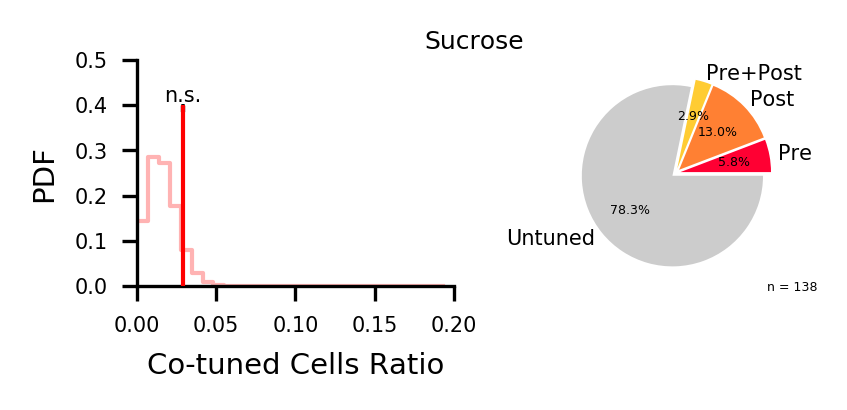

In [110]:
pop1 = cells_pre_rew
pop2 = cells_post_rew
unt = ~(cells_pre_rew + cells_post_rew)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops)

fig, axs = plot_it(pop1, pop2, unt, est)
fig.savefig('../img/cotuned_suc_prepost.pdf')

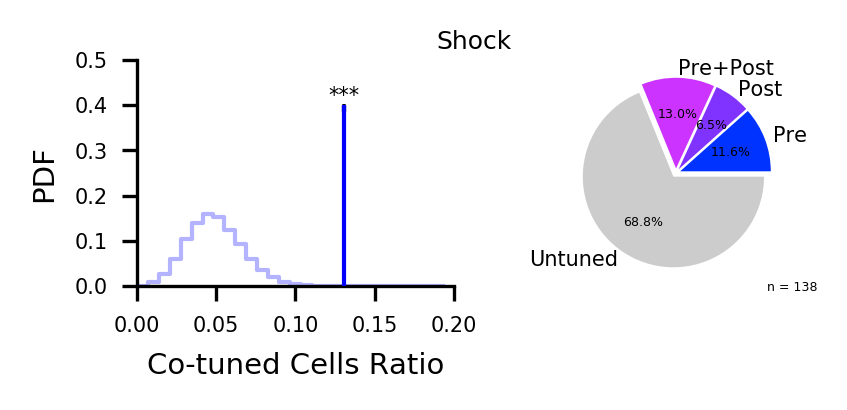

In [111]:
pop1 = cells_pre_sho
pop2 = cells_post_sho
unt = ~(cells_pre_sho + cells_post_sho)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops)

colors = [(0, 0.2, 1), (0.5, 0.2, 1), (0.8, 0.2, 1), (0.8, 0.8, 0.8)]
fig, axs = plot_it(pop1, pop2, unt, est,
                   title='Shock', colors=colors, hist_colors=[(0.7, 0.7, 1), 'b'])
fig.savefig('../img/cotuned_sho_prepost.pdf')

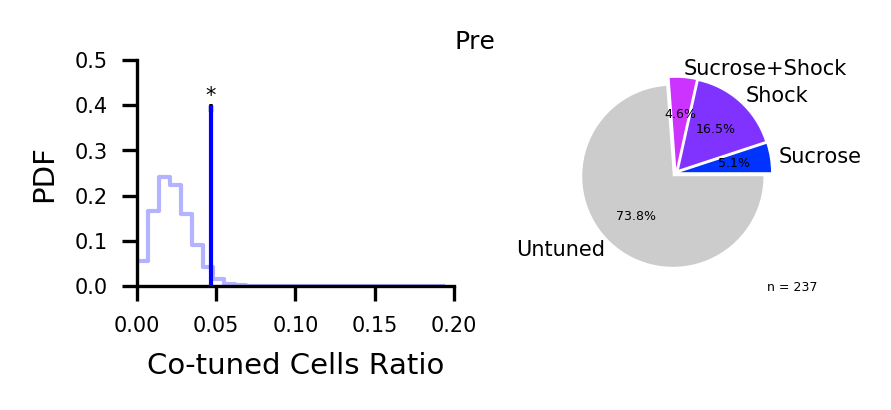

In [112]:
pop1 = cells_allpre_rew
pop2 = cells_allpre_sho
unt = ~(cells_allpre_rew+cells_allpre_sho)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops)

colors = [(0, 0.2, 1), (0.5, 0.2, 1), (0.8, 0.2, 1), (0.8, 0.8, 0.8)]
fig, axs = plot_it(pop1, pop2, unt, est,
                   title='Pre', labels=['Sucrose', 'Shock', 'Sucrose+Shock', 'Untuned'],
                   colors=colors, hist_colors=[(0.7, 0.7, 1), 'b'])
fig.savefig('../img/cotuned_sucsho_pre.pdf')

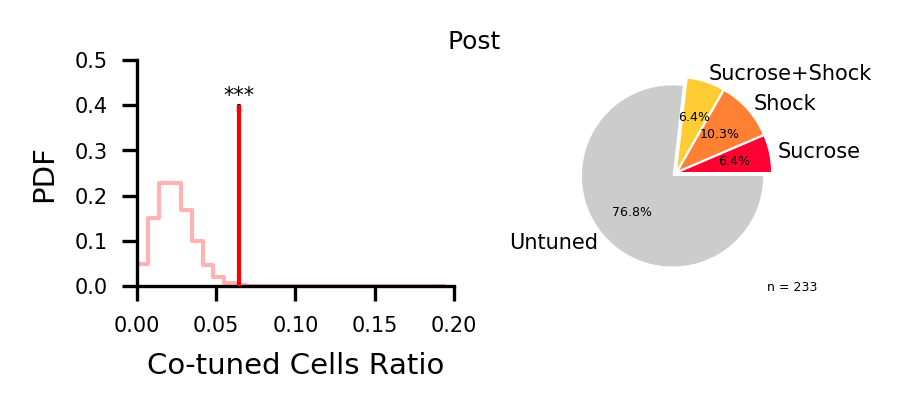

In [113]:
pop1 = cells_allpost_rew
pop2 = cells_allpost_sho
unt = ~(cells_allpost_rew + cells_allpost_sho)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops)

fig, axs = plot_it(pop1, pop2, unt, est,
                   title='Post', labels=['Sucrose', 'Shock', 'Sucrose+Shock', 'Untuned'])
fig.savefig('../img/cotuned_sucho_post.pdf')

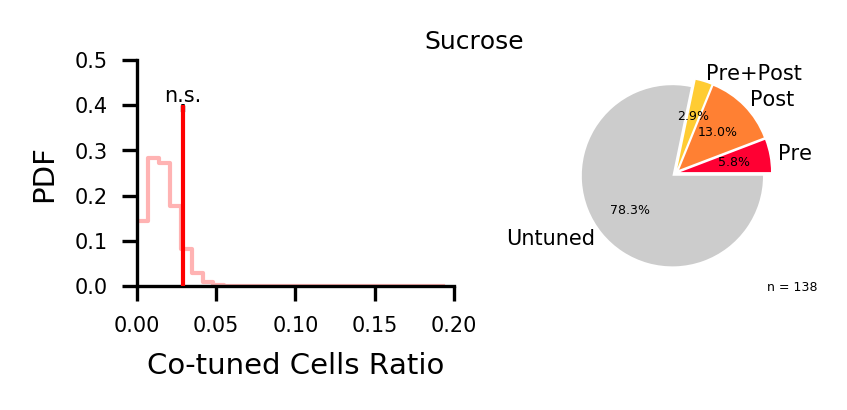

In [114]:
pop1 = cells_pre_rew_constrained
pop2 = cells_post_rew_constrained
unt = ~(cells_pre_rew_constrained + cells_post_rew_constrained)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops)

fig, axs = plot_it(pop1, pop2, unt, est)
fig.savefig('../img/cotuned_suc_prepost_constrained.pdf')

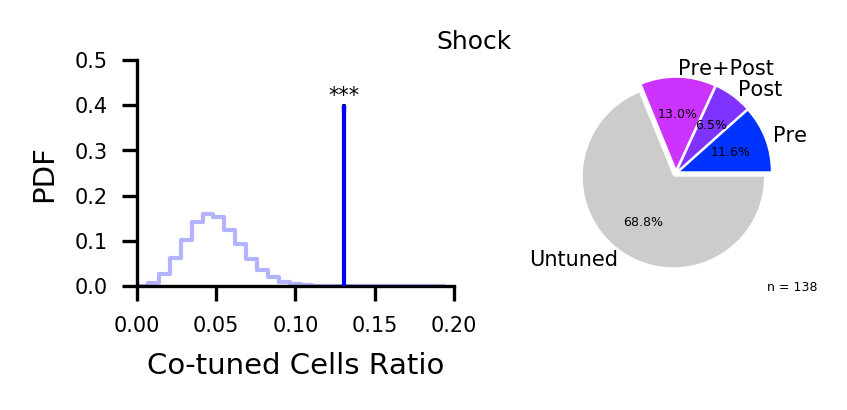

In [115]:
pop1 = cells_pre_sho_constrained
pop2 = cells_post_sho_constrained
unt = ~(cells_pre_sho_constrained + cells_post_sho_constrained)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops)

colors = [(0, 0.2, 1), (0.5, 0.2, 1), (0.8, 0.2, 1), (0.8, 0.8, 0.8)]
fig, axs = plot_it(pop1, pop2, unt, est,
                   title='Shock', colors=colors, hist_colors=[(0.7, 0.7, 1), 'b'])
fig.savefig('../img/cotuned_sho_prepost_constrained.pdf')

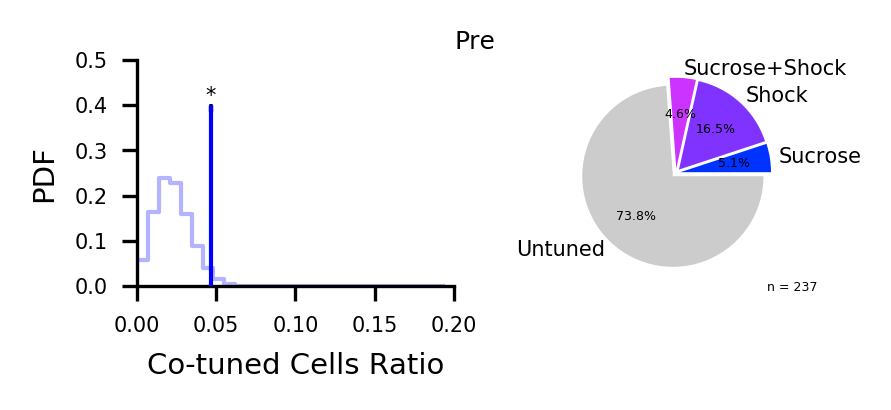

In [116]:
pop1 = cells_allpre_rew_constrained
pop2 = cells_allpre_sho_constrained
unt = ~(cells_allpre_rew_constrained+cells_allpre_sho_constrained)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops)

colors = [(0, 0.2, 1), (0.5, 0.2, 1), (0.8, 0.2, 1), (0.8, 0.8, 0.8)]
fig, axs = plot_it(pop1, pop2, unt, est,
                   title='Pre', labels=['Sucrose', 'Shock', 'Sucrose+Shock', 'Untuned'],
                   colors=colors, hist_colors=[(0.7, 0.7, 1), 'b'])
fig.savefig('../img/cotuned_sucsho_pre_constrained.pdf')

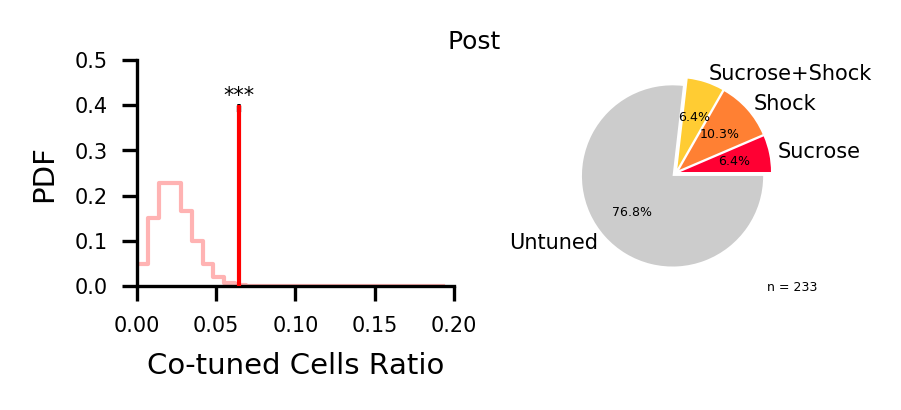

In [117]:
pop1 = cells_allpost_rew_constrained
pop2 = cells_allpost_sho_constrained
unt = ~(cells_allpost_rew_constrained + cells_allpost_sho_constrained)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops)

fig, axs = plot_it(pop1, pop2, unt, est,
                   title='Post', labels=['Sucrose', 'Shock', 'Sucrose+Shock', 'Untuned'])
fig.savefig('../img/cotuned_sucho_post_constrained.pdf')

In [101]:
save_workspace(db)

Could not store variable 'di'. Skipping...
Could not store variable 'os'. Skipping...
Could not store variable 'IPython'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'sstats'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'np'. Skipping...
Could not store variable 'sys'. Skipping...
